In [82]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [83]:
# install OpenCV
!pip install opencv-python

# the usual ...
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from skimage import img_as_float
import cv2
import scipy.linalg as la

In [84]:
#Use gray img to create Second moment matrix
def CreateEigenMat(img, window_size, sigma):
  # return 2 matrix, one stores the lamda1's value for each pixel.
  # the other stores lamda2's value.
  rows,cols = img.shape
  #blur the image to denoise
  blur = cv2.GaussianBlur(img,(5,5),7)
  
  #use Sobel filter to get img gradient
  Ix = cv2.Sobel(blur, cv2.CV_64F, 1, 0, ksize=5)
  Iy = cv2.Sobel(blur, cv2.CV_64F, 0, 1, ksize=5)
  IxIy = np.multiply(Ix, Iy)
  Ix2 = np.multiply(Ix, Ix)
  Iy2 = np.multiply(Iy, Iy)
  Ix2_blur = cv2.GaussianBlur(Ix2,window_size,sigma) 
  Iy2_blur = cv2.GaussianBlur(Iy2,window_size,sigma) 
  IxIy_blur = cv2.GaussianBlur(IxIy,window_size,sigma) 

  eigen_mat = np.zeros((rows,cols))
  lamda1 = np.zeros([rows,cols])
  lamda2 = np.zeros([rows,cols])
  for i in range(rows):
    for j in range(cols):
      M = np.zeros((2,2))
      M[0,0] = Ix2_blur[i,j]
      M[0,1] = IxIy_blur[i,j]
      M[1,0] = IxIy_blur[i,j]
      M[1,1] = Iy2_blur[i,j]
      #calulate eigenvalues for this pixel
      eigvals, eigvecs = la.eig(M)
      #M is symmetric, eigenvalues are real([ 1. -2.])
      eigvals = eigvals.real
      lamda1[i,j] = eigvals[0]
      lamda2[i,j] = eigvals[1]
  return lamda1,lamda2


In [85]:
def Threshold(lamda1,lamda2):
  lamda1_thres = 0.05*np.max(lamda1)
  lamda2_thres = 0.05*np.max(lamda2)

  Threshold = min(lamda1_thres,lamda2_thres)
  print('lamda1_thres is,', lamda1_thres)
  print('lamda2_thres is,',lamda2_thres)
  print('Threshold is,', Threshold)
  return Threshold

def harris_corner_detector(img,thres,lamda1, lamda2):
  #Draw the corner on the original colorful img
  rows,cols = img.shape[0:2]
  for i in range(rows):
    for j in range(cols):
      if min(lamda1[i,j],lamda2[i,j])>thres:
       #This pixel is a corner
        img[i,j,:] = (255,0,0)
  return img

In [86]:
# read an image (make sure CavePainting.jpg is in the main folder in your Google Drive)
img = cv2.imread('/content/drive/My Drive/Colab Notebooks/Assignments/A2/image2.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
print(img.shape)
lamda1,lamda2 = CreateEigenMat(gray,(21,21), 3)
print(lamda1.shape)

(720, 1080, 3)
(720, 1080)


In [87]:
thres = Threshold(lamda1,lamda2)
image = harris_corner_detector(img,thres,lamda1,lamda2)

lamda1_thres is, 692458.4270017137
lamda2_thres is, 678448.6100423993
Threshold is, 678448.6100423993


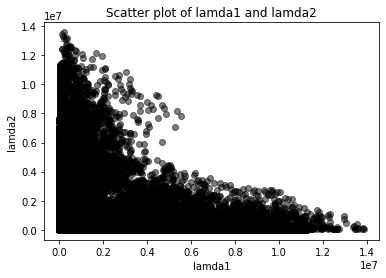

In [88]:
#draw the scatterplot
area = np.pi*3
flatten_lamda1 = lamda1.flatten()
flatten_lamda2 = lamda2.flatten()
plt.scatter(flatten_lamda1,flatten_lamda2, c='black',alpha=0.5)
plt.title('Scatter plot of lamda1 and lamda2')
plt.xlabel('lamda1')
plt.ylabel('lamda2')
plt.show()


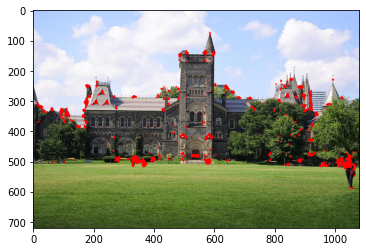

In [89]:
plt.imshow(image)